# This deals with multiple realizations and HOD parameters

In [46]:
#Author: Shadab Alam : salam@roe.ac.uk
#Create a file to list all the parameters of cosmology in Abacus simulation
from __future__ import print_function

#####importing the necessary libraries
#To make the plots inline otherwise it will make seperate figure
%matplotlib inline 
#for high resolution plot outputs
%config InlineBackend.figure_format = 'retina'

import numpy as np

import os
import sys

#latex display
from IPython.display import Latex


####plottinng library and setting
import pylab as pl
import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(ticks=True, grid=False, figsize=(10, 8))

# reset default matplotlib rcParams
jtplot.reset()

# Intro:
This notebook provide basic function to load the parameters and measurements and make some preliminary plots.
We are using Abacus Nbody simulation to study the ability to cosmological parameter sensitivity on various observables. You can learn more about Abacus suites of Nbody simulation here: https://lgarrison.github.io/AbacusCosmos/simulations/

We have taken the 720 Mpc/h box from Abaxus suit and created mock galaxy catalogue representing GAMA sample at low redshift with r band absolute limit of -21. The 40 different cosmology are populated and should be used for this study. The over all goal will to understand the information content in different observable for which we will use fisher technique. Please read section 5 of https://arxiv.org/pdf/1911.11158.pdf paper for description of how such method can be used.

Our longer term goal will be to use projected correlation function (wp), multipole moments (xi_ell), Vornois Volume Function (VVF) and Void probability function (VPF) in this exrcise. 

Currently we have wp, and xis024 available which will be our starting point.

So, the notebook provide how to access, load and plot these measurements including corresponding cosmological parameters.

The clustering file structure:
For each sim we assign a simname which is either planck or interget with two digit (00-39) and file names are:
<simaname>-wpxis024xi2dsmall-logr.txt
    
The file consists of mean measurement as well as jacknife realization. For a description of jackknife realizations please look at the tutorial on LSS:

The header of the file is as follows:
#wp xir-small-mu0 xi0 xir-small-mu1 xi2 xir-small-mu2 xi4 with jacknife NJN=225
#njn= 225
#nwp= 25
#nsxi= 6
#nssmall= 5
#r(Mpc/h) mean sigma All jacknifecolumns


# Function to get he cosmological parameters and measurement file names

In [5]:
def GetAbacus_param(simnum=0,rootdir='',hod='default',hod_sign=None,real=0,
                    boxsize=720,redshift='z0.100'):
    '''Reads the parameters for sim num from a file list'''
    #parlist_file=rootdir+'AbacusCosmos_%dbox_cosmo.parlist'%(boxsize)
    parlist_file='WPXIS024XI2DSMALL/AbacusCosmos_720box/AbacusCosmos_720box_cosmo.parlist'
    #dictionary to hold parameters and returns
    pardic={}
    
    #read param lists
    lines=open(parlist_file).readlines()
    for tt,tline in enumerate(lines):
        if('#params' in tline):
            plist_str=tline[:-1].split(':')[-1]
            tspl_plist=plist_str.split(',')
            break
    
    if(simnum=='planck'):
        simname=simnum
        for tt,tline in enumerate(lines):
            if('#planck' in tline):
                tspl=tline.split()
                for ii, par in enumerate(tspl_plist):
                    if(ii==0):
                        pardic[par]=simnum
                    else:
                        pardic[par]=np.float(tspl[ii])
    else:
        simname=str(simnum).zfill(2)
        #load the values of parameters
        data=np.loadtxt(parlist_file)
        #select the appropriate sim
        ind_sel=np.where(data[:,0]==simnum)[0][0]
        #populate the dictionary for selected sim num

        for ii, par in enumerate(tspl_plist):
            pardic[par]=data[ind_sel,ii]

         
    #LOAD THE HALO PARAMETERS
    pardic,hod_tag=Get_hod_parameter(pardic,Mr=21,hod=hod,hod_sign=hod_sign)
            
    #halo_dir=halo_file(rootdir=rootdir,simname=simname,boxsize=boxsize,redshift=redshift)
    #pardic['halo_dir']=halo_dir
    
    hod_dir=['AbacusCosmos_720box_rockstar_halos_z0.100_Mr21_hod-',
            '_real-',
            '.gcat.rsd_zz.1pz0.100by100']
    
    clustering_dir='%sWPXIS024XI2DSMALL/%s%s%s%d%s/'%(rootdir,hod_dir[0],hod_tag,hod_dir[1],real,hod_dir[2])
    
    clustering_file=clustering_dir+simname+'-wpxis024xi2dsmall-logr.txt'
    
    
    pardic['clustering_file']=clustering_file
    pardic['simname']=simname
    
    #VVF file
    #vvf_file=vvfrootdir+simname+'-vvf.txt'
    vvf_dir='%sVVF/%s%s%s%d%s/'%(rootdir,hod_dir[0],hod_tag,hod_dir[1],real,hod_dir[2])
    
    vvf_file=vvf_dir+simname+'-vvf-RF-500.txt'
    pardic['vvf_file']=vvf_file
    
    return pardic

def get_delta_HOD_par():
    delta_hod={'kappa': 0.5,'LMcut': 0.2, 'fconc': 0.3, 'LM1': 0.2,
               'fradsat':1.0,'alpha':0.5,'gammaHV':0.2,'sigma':0.2,
               'gammaIHV':0.5
              }
    
    return delta_hod


def Get_hod_parameter(dicin,Mr=21,hod='default',hod_sign=None):
    '''This return the HOD parameters'''
    if(Mr==21):
        default_hod={'kappa': 2.31,'LMcut': 12.64, 'fconc': 0.26, 
                 'LM1': 13.58,'fradsat':1.21,'alpha':0.71,
                 'gammaHV':1.32,'sigma':0.77,
               'gammaIHV':0.577,
              }
    
    delta_hod=get_delta_HOD_par()
    
    if(hod=='default' or hod_sign==None):
        hod_tag='%s'%hod
    elif(hod_sign!=None):
        hod_tag='%s-%s'%(hod,hod_sign)

    
    for tt,tkey in enumerate(default_hod.keys()):
        if(tkey in hod and hod_sign=='pos'):
            dp=delta_hod[tkey]
        elif(tkey in hod and hod_sign=='neg'): 
            dp=-delta_hod[tkey]
        else:
            dp=0
            
        dicin[tkey]=default_hod[tkey]+dp
    
    
    return dicin ,hod_tag

Mr=21
#rootdir='WPXIS024XI2DSMALL/AbacusCosmos_720box/'
rootdir='GCAT_v9July2021/'
#vvfrootdir='VVF/AbacusCosmos_720box_rockstar_halos_z0.100_Mr21.gcat.rsd_zz.1pz0.100by100/'
GetAbacus_param(simnum='planck',rootdir=rootdir,hod='default',hod_sign=None,real=0,
                boxsize=720,redshift='z0.100')

res=Get_hod_parameter({},Mr=21,hod='default',hod_sign='pos')
print(res)

({'kappa': 2.31, 'LMcut': 12.64, 'fconc': 0.26, 'LM1': 13.58, 'fradsat': 1.21, 'alpha': 0.71, 'gammaHV': 1.32, 'sigma': 0.77, 'gammaIHV': 0.577}, 'default')


# Function to load the clustering measurement

In [16]:
def load_clustering(simnum,rootdir='',hod='default',hod_sign=None,real=0): 
    '''loads the clustering measurements'''
    
    #first load the basic parameters
    res_dic=GetAbacus_param(simnum=simnum,rootdir=rootdir,hod=hod,hod_sign=hod_sign,real=real,
                            boxsize=720,redshift='z0.100')
    
    #print('fname:',res_dic['clustering_file'])
    res_dic['xidata']=np.loadtxt(res_dic['clustering_file'])
    
    #loading the details of data vector header
    tmpline=open(res_dic['clustering_file'],'r').readlines()
    ngot=0
    for ii, tline in enumerate(tmpline):
        if('#njn=' in tline):
            res_dic['njn']=np.int(tline.split()[1]);
        elif('#nwp=' in tline):
            res_dic['nwp']=np.int(tline.split()[-1])
            ngot=ngot+1
        elif('#nsxi=' in tline):
            res_dic['nsxi']=np.int(tline.split()[-1])
            ngot=ngot+1
        elif('#nssmall=' in tline):
            res_dic['nssmall']=np.int(tline.split()[-1])
            ngot=ngot+1
        elif('#order=' in tline):
            res_dic['stats_order']=tline.split()[1:];

        
        #if(ngot>=2 and smallscale_split==0):
        #    break
        if(ngot>=5):
            break
            
    res_dic['beg_index']=0
    
    return res_dic

def get_simkey(simnum,hod,hod_sign,real=0):
    if(hod!='default'):
        simkey='%s-%s-%s-%d'%(simnum,hod,hod_sign,real)
    else:
        simkey='%s-%s-%d'%(simnum,hod,real)
        
    return simkey

def get_HODpar_list(simnum):
    if(simnum=='planck'):
        hod_pars=['default','kappa', 'LMcut', 'fconc', 'LM1', 'fradsat', 'alpha', 'gammaHV', 'sigma', 'gammaIHV']
        hod_sign=['pos','neg']
    else:
        hod_pars=['default']
        hod_sign=[None]
    return hod_pars,hod_sign

simnum_list=['planck']


for ii in range(0,40):
    simnum_list.append(ii)            

res_sims={}
real_lim=[0,1]


for ss,simnum in enumerate(simnum_list):
    hod_pars,hod_sign_list=get_HODpar_list(simnum)
        
    for hh,hod in enumerate(hod_pars):
        for ss,hod_sign in enumerate(hod_sign_list):
            if(hod=='default' and ss!=0):
                continue

            print(simnum,hod,hod_sign)
            for real in range(real_lim[0],real_lim[1]):
                res_sims[get_simkey(simnum,hod,hod_sign,real=real)]=load_clustering(simnum,rootdir=rootdir,
                                                                      hod=hod,hod_sign=hod_sign,real=real)

            
            
print('Finished')


planck default pos
planck kappa pos
planck kappa neg
planck LMcut pos
planck LMcut neg
planck fconc pos
planck fconc neg
planck LM1 pos
planck LM1 neg
planck fradsat pos
planck fradsat neg
planck alpha pos
planck alpha neg
planck gammaHV pos
planck gammaHV neg
planck sigma pos
planck sigma neg
planck gammaIHV pos
planck gammaIHV neg
0 default None
1 default None
2 default None
3 default None
4 default None
5 default None
6 default None
7 default None
8 default None
9 default None
10 default None
11 default None
12 default None
13 default None
14 default None
15 default None
16 default None
17 default None
18 default None
19 default None
20 default None
21 default None
22 default None
23 default None
24 default None
25 default None
26 default None
27 default None
28 default None
29 default None
30 default None
31 default None
32 default None
33 default None
34 default None
35 default None
36 default None
37 default None
38 default None
39 default None
Finished


# Functions to plot the clustering measurement

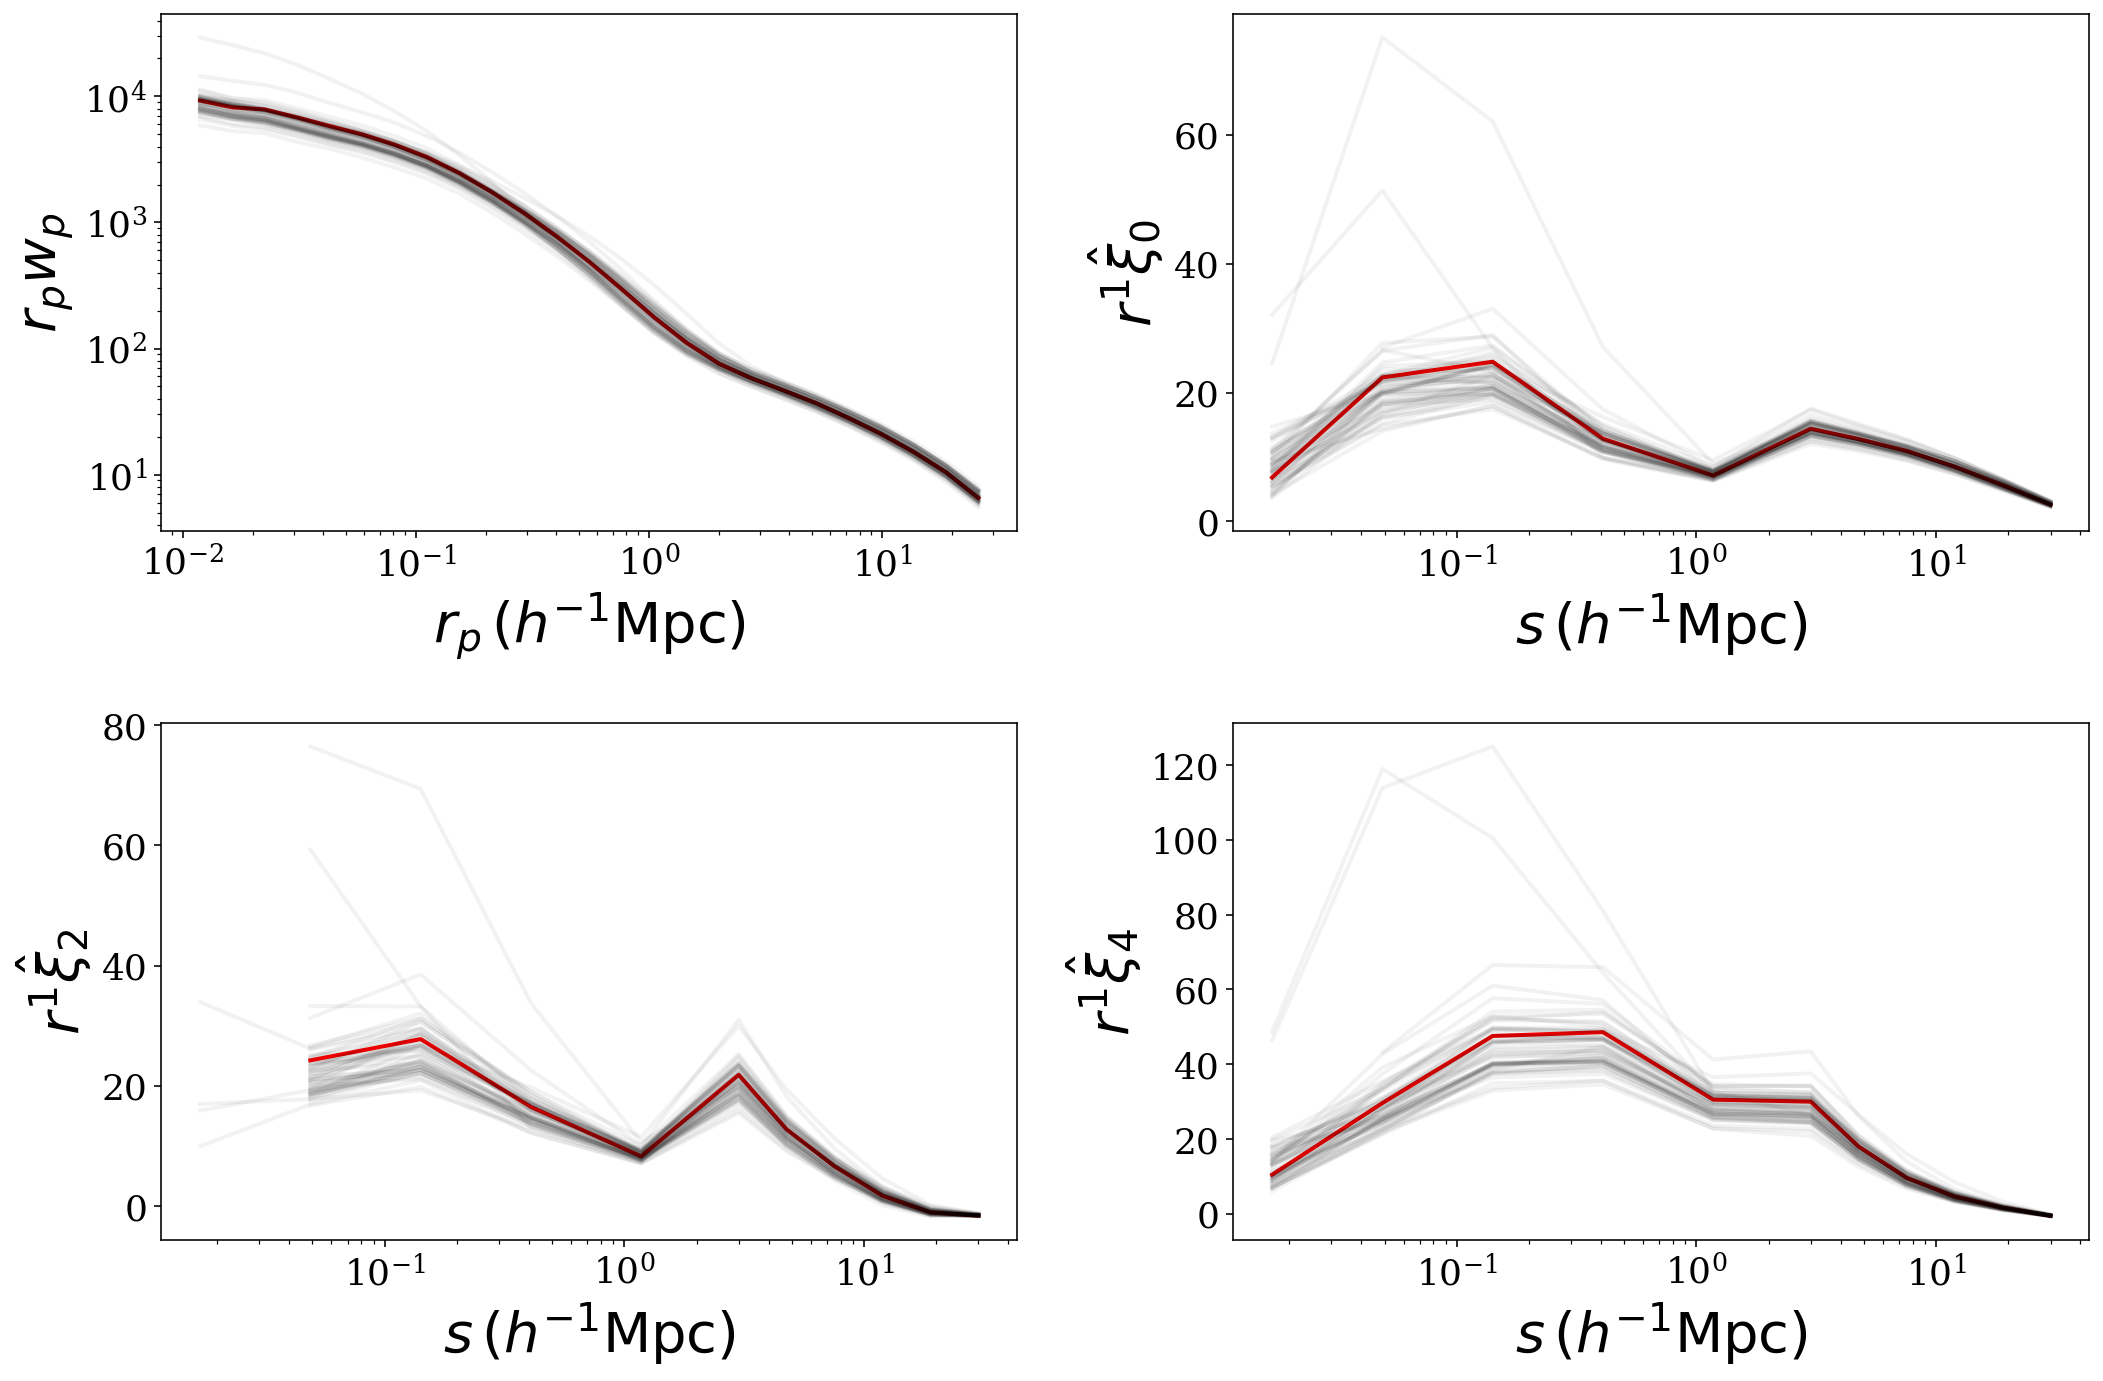

In [17]:
def plot_clustering(indic,axarr,color=None,werr=False,
                    marker='-',fmt='o',lab=None,frp_pow=1,r2tag='r^1',refdic={},axlabel=False,alpha=0.5):
    '''plots the clustering results'''
    
    tdic=indic['xidata']
    
    if(refdic=={}):
        refwpxi=np.ones(tdic.shape[0]);
    else:
        refwpxi=refdic['xidata']

    
    #first make the wp plot
    #The bi and ei decide the range of wp indices
    bi=indic['beg_index']; ei=indic['beg_index']+indic['nwp']
    frp=np.power(tdic[bi:ei,0],frp_pow)
    xval=np.power(10,np.log10(tdic[bi:ei,0]))
    if(werr==True):
        axarr[0].errorbar(xval,frp*tdic[bi:ei,1]/refwpxi[bi:ei],
                            yerr=frp*tdic[bi:ei,2]/refwpxi[bi:ei],
                  fmt=fmt,lw=2,color=color,markersize=6,mfc='w',label=lab)
    else:
        axarr[0].plot(xval,frp*tdic[bi:ei,1]/refwpxi[bi:ei],lw=2,color=color,alpha=alpha,label=lab)

    #print(simnum,bi,ei)

    for ii,pole in enumerate([0,2,4]):
        #decide the range of various indices of multipole moments
        ind1=indic['beg_index']+indic['nwp']+(ii*(indic['nsxi']+indic['nssmall'])); 
        ind2=ind1+indic['nsxi']+indic['nssmall']
        #print('pole:',pole,ind1,ind2)
        if(r2tag==''):
            rpow=0
        elif(r2tag=='r^1'):
            rpow=1
        else:
            rpow=2

        r2=np.power(tdic[ind1:ind2,0],rpow)
        #plot of data
        #xval=tdic[ind1:ind2,0]
        xval=np.power(10,np.log10(tdic[ind1:ind2,0]))
        if(werr==True):
            axarr[ii+1].errorbar(xval,r2*tdic[ind1:ind2,1]/refwpxi[ind1:ind2],
                                   yerr=r2*tdic[ind1:ind2,2]/refwpxi[ind1:ind2],
                             fmt=fmt,lw=2,color=color,markersize=6,mfc='w')#,label='M_r>-%d'%Mr)
        else:
            axarr[ii+1].plot(xval,r2*tdic[ind1:ind2,1]/refwpxi[ind1:ind2],
                             lw=2,color=color,alpha=alpha)
            
    #labeling etc
    if(axlabel==True):
        #labeling the plot
        pl.sca(axarr[0]);
        pl.xlabel(r'$r_p \,(h^{-1}{\rm Mpc})$',fontsize=28)
        pl.ylabel(r'$r_p w_p$',fontsize=28)
        pl.xscale('log');
        if(refdic=={}):
            pl.yscale('log')
        #pl.legend(fontsize=13,ncol=2,loc=2)

        for ii,pole in enumerate([0,2,4]):
            pl.sca(axarr[ii+1])
            pl.xlabel(r'$s \,(h^{-1}{\rm Mpc})$',fontsize=28)

            pl.ylabel(r'$%s \hat{\xi}_%d$'%(r2tag,pole),fontsize=28)
            pl.xscale('log')
            #pl.yscale('symlog')
            #pl.ylim([0,500])
            if(refdic=={} and r2tag==''):
                pl.yscale('log')
            elif(refdic!={}):
                if(pole>0):
                    pl.ylim([0,2])

            #pl.legend(fontsize=13)

nrow=2;ncol=2
fig,axarr=pl.subplots(nrow,ncol,sharex=False,sharey=False,figsize=(15,nrow*5))
axarr=axarr.reshape(axarr.size)

refdic={}
r2tag='r^1'

for ss,simnum in enumerate(simnum_list):
    hod_pars,hod_sign_list=get_HODpar_list(simnum)
    
    for hh,hod in enumerate(hod_pars):
        for ss,hod_sign in enumerate(['pos','neg']):
            if(hod=='default' and ss!=0):
                continue
            res_dic=res_sims[get_simkey(simnum,hod,hod_sign,real=0)]
            if(hh==0):
                axlabel=True
            else:
                axlabel=False
                
            if(simnum=='planck' and hod=='default'):
                tcol='r';alpha=1.0
            else:
                tcol='k' ;alpha=0.05   
                
            plot_clustering(res_dic,axarr,frp_pow=0,r2tag=r2tag,color=tcol,werr=False,
                            marker='-',lab=get_simkey(simnum,hod,hod_sign),refdic=refdic,axlabel=axlabel,alpha=alpha)



pl.sca(axarr[0])
#pl.legend(fontsize=10,ncol=4)
pl.tight_layout()


# Function to load the vvf


In [30]:
def load_vvf(simnum,rootdir='',hod='default',hod_sign=None,real=0): 
    '''loads the vvf measurements'''
    
    #first load the basic parameters
    res_dic=GetAbacus_param(simnum=simnum,rootdir=rootdir,hod=hod,hod_sign=hod_sign,real=real,
                            boxsize=720,redshift='z0.100')
    
    res_dic['vvf']=np.loadtxt(res_dic['vvf_file'])
    if(os.path.isfile(res_dic['vvf_file']+'.hist')):
        res_dic['vvfhist']=np.loadtxt(res_dic['vvf_file']+'.hist')
    #print(res_dic['vvf_file'])
    
    #loading the details of data vector header
    tmpline=open(res_dic['vvf_file'],'r').readlines()
    ngot=0
    for ii, tline in enumerate(tmpline):
        if('# stats order in row:' in tline):
            tstat=tline.split(':')[1][:-1]
            tspl=tstat.split(',')
            for tt,tmp in enumerate(tspl):
                tspl[tt]=tmp.strip()
            res_dic['stats_order']=tspl
            

        
        #if(ngot>=2 and smallscale_split==0):
        #    break
        if(ngot>=5):
            break
            
    res_dic['beg_index']=0
    res_dic['simnum']=simnum
    
    return res_dic


res_vvf={}
for ss,simnum in enumerate(simnum_list):
    hod_pars,hod_sign_list=get_HODpar_list(simnum)
    for hh,hod in enumerate(hod_pars):
        for ss,hod_sign in enumerate(['pos','neg']):
            if(hod=='default' and ss!=0):
                continue

            for real in range(real_lim[0],real_lim[1]):
                res_vvf[get_simkey(simnum,hod,hod_sign,real=real)]=load_vvf(simnum,
                            rootdir=rootdir,hod=hod,hod_sign=hod_sign,real=real)

print('done')

done


# To plot the VVF

0 0 0
1 0 1
1 0 1
2 0 2
2 0 2
3 0 3
3 0 3
4 0 4
4 0 4
5 0 5
5 0 5
6 0 6
6 0 6
7 0 7
7 0 7
8 0 8
8 0 8
9 0 9
9 0 9
0 1 10
0 2 20
0 3 30
0 4 40
0 5 50
0 6 60
0 7 70
0 8 80
0 9 90
0 10 100
0 11 110
0 12 120
0 13 130
0 14 140
0 15 150
0 16 160
0 17 170
0 18 180
0 19 190
0 20 200
0 21 210
0 22 220
0 23 230
0 24 240
0 25 250
0 26 260
0 27 270
0 28 280
0 29 290
0 30 300
0 31 310
0 32 320
0 33 330
0 34 340
0 35 350
0 36 360
0 37 370
0 38 380
0 39 390


No handles with labels found to put in legend.


0 40 400


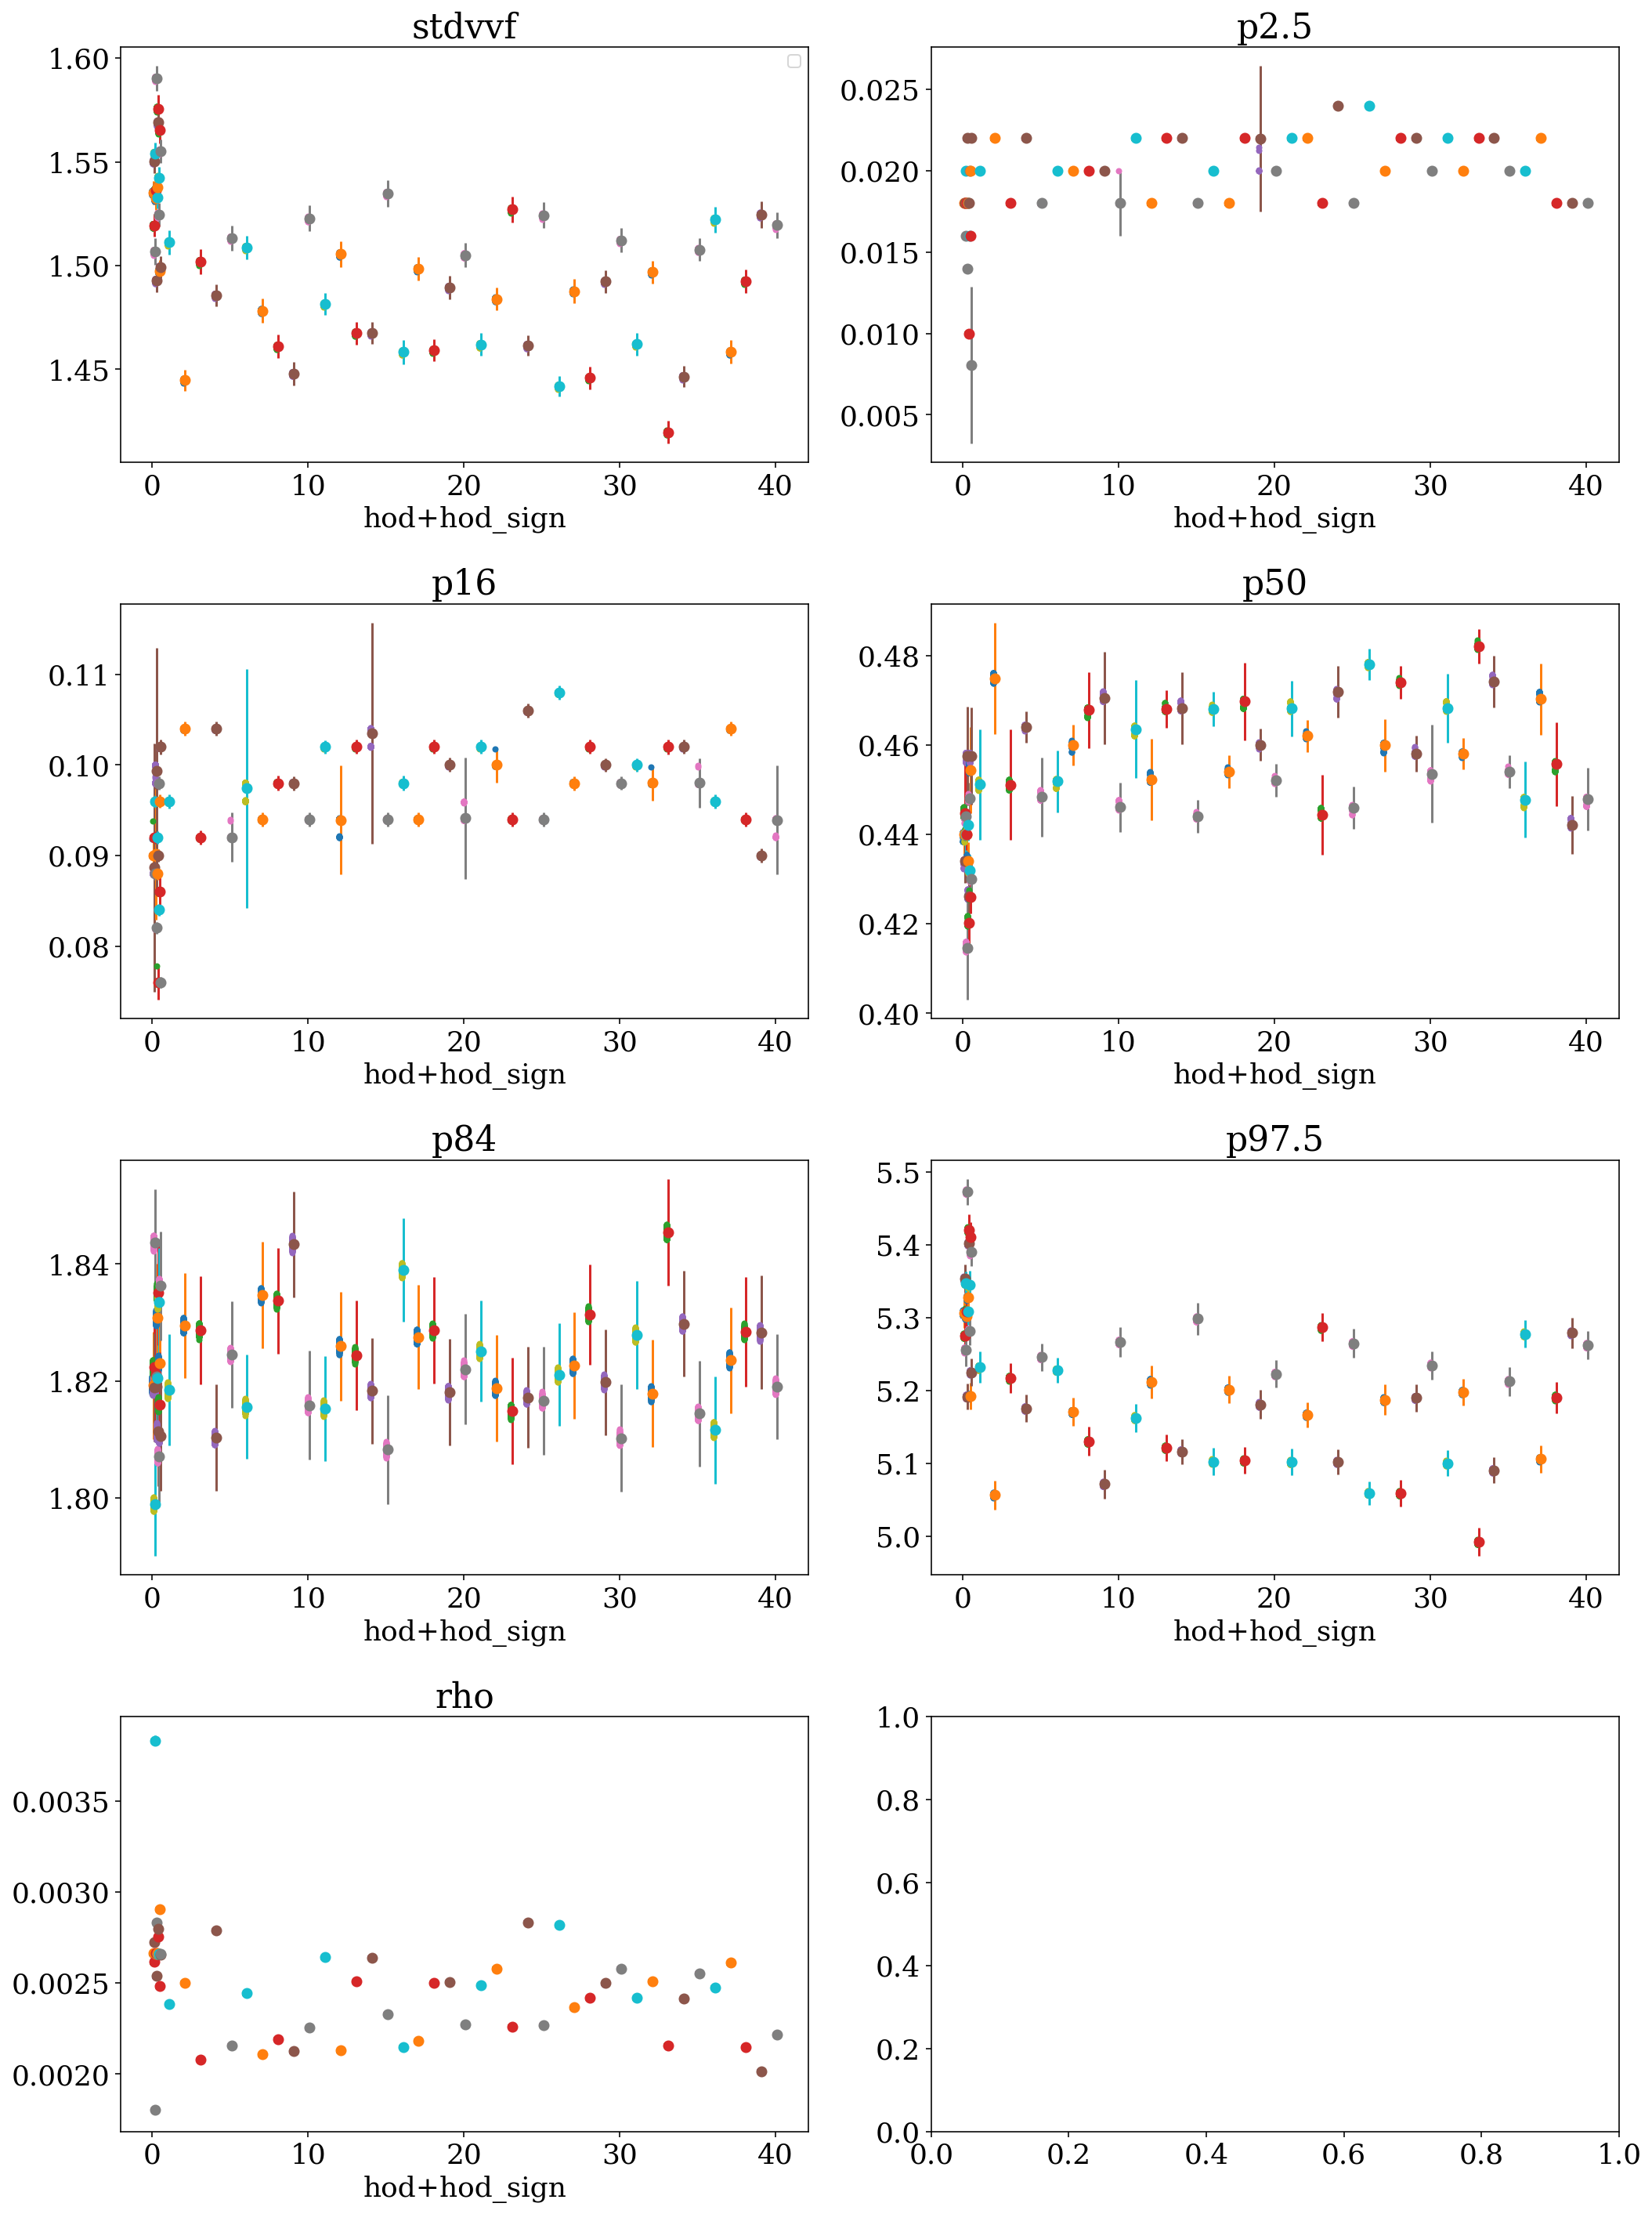

In [25]:
def plot_vvf(simnum,res_dic,axarr,color=None,werr=False,
                    marker='-',refdic=refdic,axlabel=axlabel):
    '''Note for some of the sims error in p2.5 and p16 is very large.
    This is probably due to stochastic noise in the measurements, 
    we should deal with it by averaging over several realizations at a later stage'''
    
    if(simnum=='planck'):
        sin=-1
    else:
        sin=simnum
    for ss, stat in enumerate(res_dic['stats_order']):
        pl.sca(axarr[ss])
        pl.plot(sin*np.ones(225),res_dic['vvf'][ss,4:],'.')
        pl.errorbar(sin+0.1,res_dic['vvf'][ss,1],yerr=res_dic['vvf'][ss,2],fmt='o')
        #print(ss,stat)
        pl.title(stat,fontsize=22)
        pl.xlabel('hod+hod_sign',fontsize=18)
        
    return


nrow=4;ncol=2
fig,axarr=pl.subplots(nrow,ncol,sharex=False,sharey=False,figsize=(15,nrow*5))
axarr=axarr.reshape(axarr.size)

refdic={}
r2tag='r^1'

for ss,simnum in enumerate(simnum_list):
    hod_pars,hod_sign_list=get_HODpar_list(simnum)
    for hh,hod in enumerate(hod_pars):
        for hs,hod_sign in enumerate(['pos','neg']):
            if(hod=='default' and hs!=0):
                continue
                
            res_dic=res_vvf[get_simkey(simnum,hod,hod_sign,real=0)]

            if(ss==0):
                axlabel=True
            else:
                axlabel=False
            print(hh,ss,hh+ss*10)
            plot_vvf(ss+hh*0.05,res_dic,axarr,color=None,werr=False,
                            marker='-',refdic=refdic,axlabel=axlabel)



pl.sca(axarr[0])
pl.legend(fontsize=10,ncol=4)
pl.tight_layout()


No handles with labels found to put in legend.
No handles with labels found to put in legend.


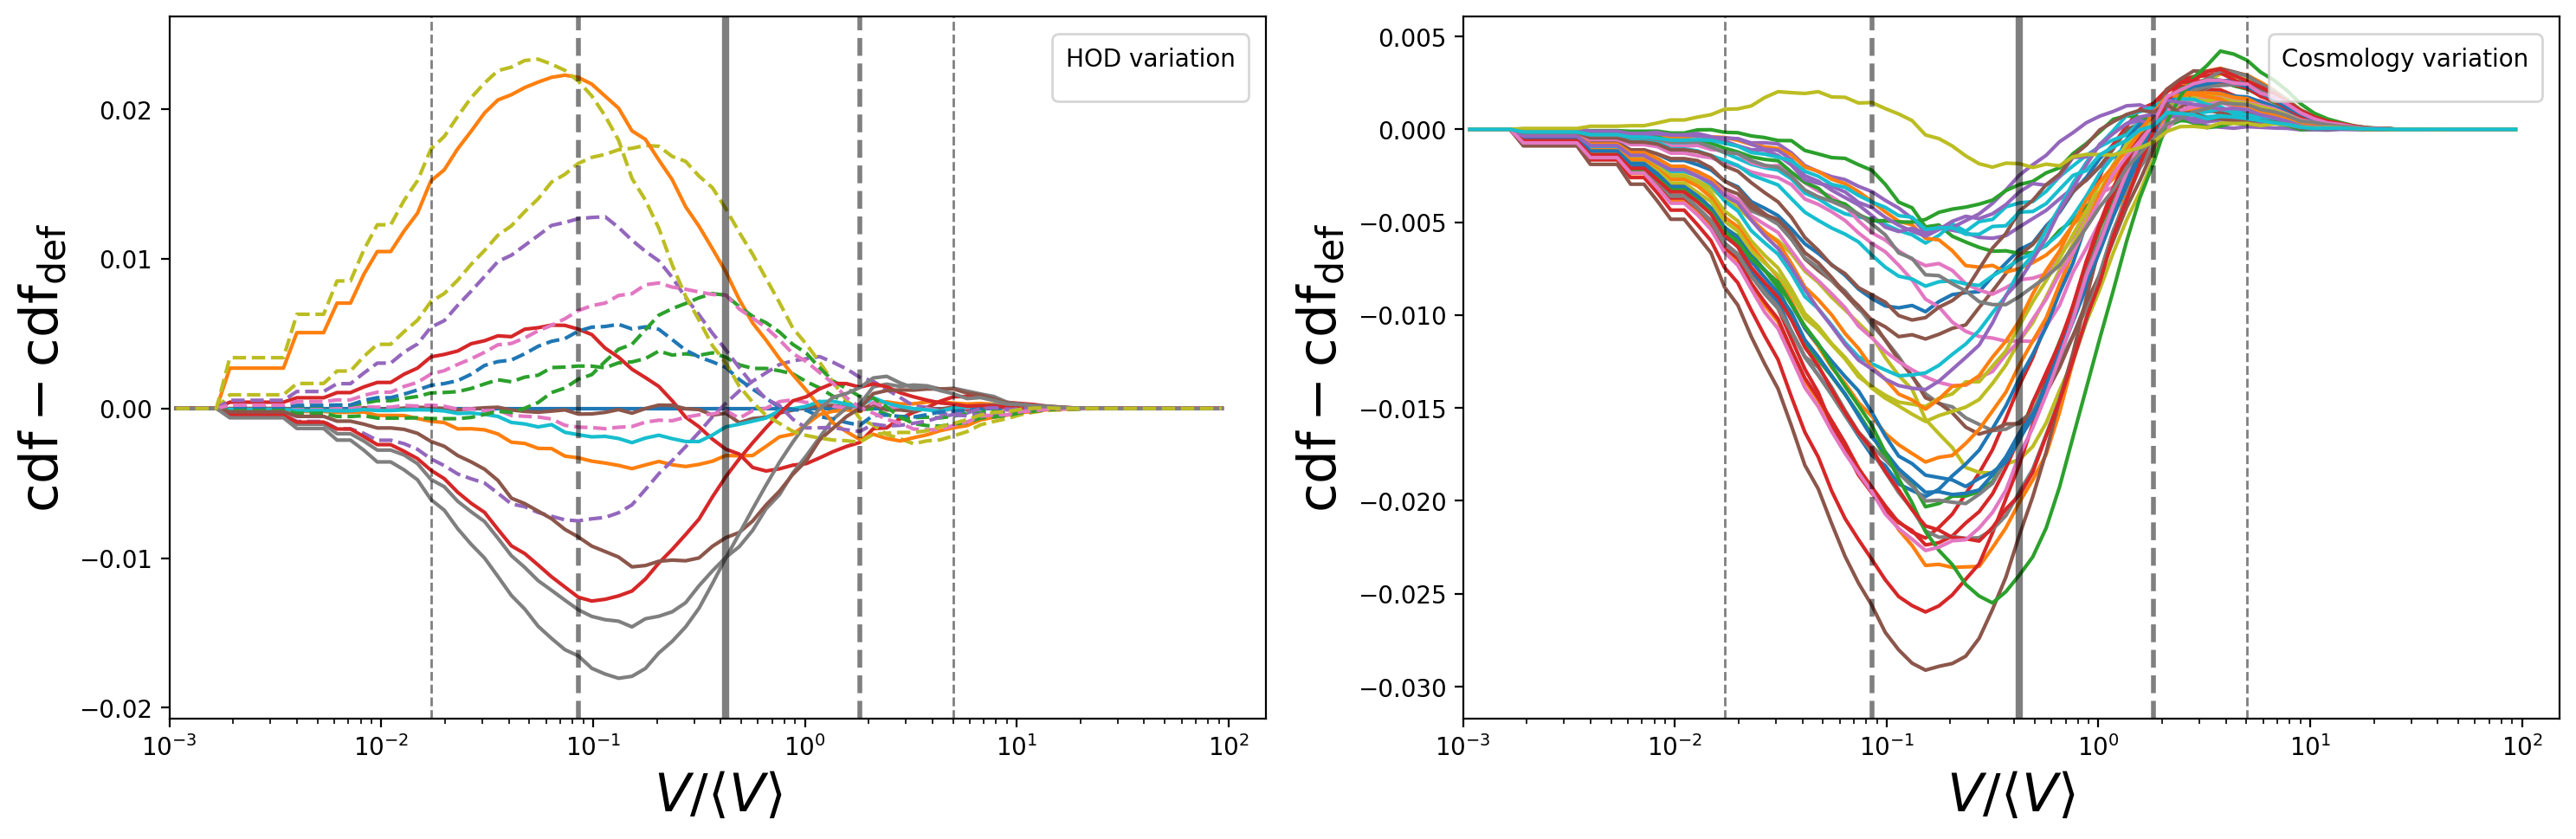

In [67]:
def plot_vvfhist(res_dic,ax=None,color=None,werr=False,
                    marker='-',refdic={},axlabel=axlabel,plots=True):
    '''Note for some of the sims error in p2.5 and p16 is very large.
    This is probably due to stochastic noise in the measurements, 
    we should deal with it by averaging over several realizations at a later stage'''
    
    vvfhist=res_dic['vvfhist']
    cumhist=np.cumsum(vvfhist[:,1])
    cumhist=cumhist/cumhist[-1]
    cumhist=np.column_stack([np.power(10,vvfhist[:,0]),cumhist])
    
    if(refdic!={}):
        cumhist[:,1]=cumhist[:,1]-refdic['cumhist'][:,1]
        
    
    if(plots):
        if(ax is not None):
            pl.sca(ax)
        pl.plot(cumhist[:,0],cumhist[:,1],marker,color=color)

        pl.xscale('log')
    
    return cumhist

def plot_percentiles(ax,cumhist,plim=[0.025,0.16,0.5,0.84,0.975],alpha=0.5):
    '''plots vertical lines for percentiles'''
    
    ls=['--','--','-','--','--']
    lw=[1,2,3,2,1]
    
    ylim=list(ax.get_ylim())
    #print(ylim)
    #ylim=ax.get_ybound()
    #increase these limits by +-5%
    ylim[0]=ylim[0]*1.03
    ylim[1]=ylim[1]*1.03
    
    #ylim=[-0.3,0.3]
    if(isinstance(plim,list)):
        plim=np.array(plim)

    
    ind_lim=np.argmin(np.abs(cumhist[:,1,None]-plim[None,:]),axis=0)

    
    for ii,ival in enumerate(ind_lim):
        ax.plot([cumhist[ival,0],cumhist[ival,0]],ylim,color='k',ls=ls[ii],lw=lw[ii],alpha=alpha)
    
    ax.set_ylim(ylim)
    ax.set_xlim([1e-3,150])
    
    return


nrow=1;ncol=2
fig,axarr=pl.subplots(nrow,ncol,sharex=False,sharey=False,figsize=(15,nrow*5))
axarr=axarr.reshape(axarr.size)

mark_dic={'pos':'-','neg':'--'}

if(False):
    refdic={}
else:
    refdic=res_vvf[get_simkey('planck','default',None,real=0)]
    refdic['cumhist']=plot_vvfhist(refdic,plots=False)

for ss,simnum in enumerate(simnum_list):
    hod_pars,hod_sign_list=get_HODpar_list(simnum)
    
    if(simnum=='planck'):
        ax=axarr[0]
    else:
        ax=axarr[1]
    
    for hh,hod in enumerate(hod_pars):
        for hs,hod_sign in enumerate(['pos','neg']):
            if(hod=='default' and hs!=0):
                continue
                
            res_dic=res_vvf[get_simkey(simnum,hod,hod_sign,real=0)]

            if(ss==0):
                axlabel=True
            else:
                axlabel=False

            plot_vvfhist(res_dic,ax,color=None,werr=False,
                            marker=mark_dic[hod_sign],refdic=refdic,axlabel=axlabel)


for aa,ax in enumerate(axarr):
    pl.sca(ax)
    
    plot_percentiles(ax,refdic['cumhist'],plim=[0.025,0.16,0.5,0.84,0.975],alpha=0.5)
    
    pl.xscale('log')
    if(aa==0):
        ptag='HOD variation'
    else:
        ptag='Cosmology variation'
        
    pl.legend(loc=1,fontsize=14,ncol=2,title=ptag)
    pl.xlabel(r'$V/\left< V \right> $',fontsize=22)
    pl.ylabel(r'${\rm cdf} - {\rm cdf_{\rm def}} $',fontsize=22)
    
    pl.tight_layout()


In [ ]:

#res_dic=res_sims[get_simkey(simnum,hod,hod_sign,real=1)]

In [16]:
def plot_wp_hod(simnum='planck',hod='LMcut',real=0):
    '''plots the wp with different hod parameters'''
    
    xi_dic={}
    tkey_def=get_simkey(simnum,'default','',real=real)
    xi_dic['def']=res_sims[tkey_def]['xidata']
    
    for hod_sign in enumerate(['pos','neg']):
        tkey_this=get_simkey(simnum,hod,hod_sign,real=real)
        xi_sign=res_sims[tkey_def]['xidata']
    

simnum_this=['planck','3']
hod='default'
hod_sign='pos'
real=0
tkey=get_simkey(simnum,hod,hod_sign,real=real)
print(res_sims[tkey]['beg_index'],res_sims[tkey]['nwp'],res_sims[tkey]['Omega_M'])#'['xidata'].shape

0 25 0.31415319


In [18]:
for tt,tkey in enumerate(res_sims.keys()):
    print(tkey,res_sims[tkey]['Omega_M'])


planck-default-0 0.31415319
planck-default-1 0.31415319
planck-default-2 0.31415319
planck-default-3 0.31415319
planck-default-4 0.31415319
planck-default-5 0.31415319
planck-default-6 0.31415319
planck-default-7 0.31415319
planck-default-8 0.31415319
planck-default-9 0.31415319
planck-kappa-pos-0 0.31415319
planck-kappa-pos-1 0.31415319
planck-kappa-pos-2 0.31415319
planck-kappa-pos-3 0.31415319
planck-kappa-pos-4 0.31415319
planck-kappa-pos-5 0.31415319
planck-kappa-pos-6 0.31415319
planck-kappa-pos-7 0.31415319
planck-kappa-pos-8 0.31415319
planck-kappa-pos-9 0.31415319
planck-kappa-neg-0 0.31415319
planck-kappa-neg-1 0.31415319
planck-kappa-neg-2 0.31415319
planck-kappa-neg-3 0.31415319
planck-kappa-neg-4 0.31415319
planck-kappa-neg-5 0.31415319
planck-kappa-neg-6 0.31415319
planck-kappa-neg-7 0.31415319
planck-kappa-neg-8 0.31415319
planck-kappa-neg-9 0.31415319
planck-LMcut-pos-0 0.31415319
planck-LMcut-pos-1 0.31415319
planck-LMcut-pos-2 0.31415319
planck-LMcut-pos-3 0.31415319
